In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# from google.colab import drive
# # drive.mount('/content/drive')
# drive.mount("/content/drive", force_remount=True)

In [3]:
# data = pd.read_csv('drive/MyDrive/Code/derived_data_csv/new_features_added_filled_nearest_neigb_min.csv')
data = pd.read_csv('./../derived_data_csv/new_features_added_filled_nearest_neigb_min.csv')


In [4]:
data.columns

Index(['city_id', 'date', 'avg_temp_c', 'min_temp_c', 'max_temp_c',
       'avg_wind_dir_deg', 'avg_wind_speed_kmh', 'city', 'day_of_week',
       'day_of_year', 'month', 'temp_range'],
      dtype='object')

In [5]:
# Python
selected_columns_to_exclude = ['date', 'city_id',
                               'snow_depth_mm', 'day_of_week']
features = [col for col in data.columns if col not in selected_columns_to_exclude]

target = 'avg_temp_c'

# Scaling features
scaler = StandardScaler()
# Python
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

In [6]:
num_rows_with_nulls = data.isnull().any(axis=1).sum()
print(f"Number of records: {len(data)}")
print(f"Number of records with at least one null value: {num_rows_with_nulls}")

Number of records: 182338
Number of records with at least one null value: 0


In [7]:
# print(data[features].head())

# data_filled = data.fillna(-1)
data.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,avg_wind_dir_deg,avg_wind_speed_kmh,city,day_of_week,day_of_year,month,temp_range
0,C001,2014-01-01,-1.244652,-1.615164,-1.181246,-0.084152,-0.825328,-1.729156,-0.500611,-1.727467,-1.601858,0.840131
1,C001,2014-01-02,-0.974157,-0.843364,-1.017647,-0.212386,-0.202979,-1.729156,-0.000590,-1.717983,-1.601858,-0.472820
2,C001,2014-01-03,-1.144469,-1.284393,-0.950283,0.157519,-0.890838,-1.729156,0.499431,-1.708498,-1.601858,0.643188
3,C001,2014-01-04,-1.144469,-1.083925,-1.017647,1.129135,0.009929,-1.729156,0.999452,-1.699014,-1.601858,0.052360
4,C001,2014-01-05,-1.044286,-1.424720,-0.671204,0.225335,-1.021859,-1.729156,1.499473,-1.689529,-1.601858,1.584136


In [8]:
city_ids = data['city_id'].unique().tolist()

In [9]:
# Create sequences for each city
def create_sequences(df, features, target, seq_length=30, pred_length=7):
    X = []
    y = []
    for i in range(len(df) - seq_length - pred_length + 1):
        X.append(df[features].iloc[i:i+seq_length].values)
        y.append(df[target].iloc[i+seq_length:i+seq_length+pred_length].values)
    return np.array(X), np.array(y)


# Split data by city and create sequences
city_data = data.groupby('city_id')
seq_length=30
X_list = []
y_list = []
last_dates = []
X_list_final = []
for i, (_, group) in enumerate(city_data):
    if i == 5:
        break
    X, y = create_sequences(group, features, target, seq_length=seq_length)
    X_list.append(X)
    y_list.append(y)
    X_last = group[features].iloc[-seq_length:].values
    X_list_final.append(X_last)

In [10]:
print(len(X_list))
print(len(y_list))
print(len(X_list[0]))
print(len(y_list[0]))
lengths = [len(element) for element in X_list]
print(lengths)
print(len(X_list[0][0]))

5
5
1790
1790
[1790, 1767, 1787, 1790, 1790]
30


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from matplotlib import pyplot as plt

In [12]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [13]:
train_ratio = 0.8
batch_size = 64

dataloaders_train = []
dataloaders_test = []

for X, y in zip(X_list, y_list):
    dataset = TimeSeriesDataset(X, y)
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(
        dataset, [train_size, test_size])

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False)

    dataloaders_train.append(train_loader)
    dataloaders_test.append(test_loader)

In [14]:
# # Convert to PyTorch tensors
# X_predict_tensor = torch.tensor(X_list_final, dtype=torch.float32).to(device)
# predict_dataset = TensorDataset(X_predict_tensor)
# predict_loader = DataLoader(predict_dataset, batch_size=1, shuffle=False)

In [15]:
# For the train loader
for i, (inputs, targets) in enumerate(train_loader):
    if i == 1:
        break
    print(f'Train Inputs Shape: {inputs.shape}, Train Targets Shape: {targets.shape}')
# For the test loader
for i, (inputs, targets) in enumerate(test_loader):
    if i == 1:
        break
    print(f'Test Inputs Shape: {inputs.shape}, Test Targets Shape: {targets.shape}')
# for i, (inputs,) in enumerate(predict_loader):
#     if i == 1:
#         break
#     print(f'Predict Inputs Shape: {inputs.shape}')

Train Inputs Shape: torch.Size([64, 30, 9]), Train Targets Shape: torch.Size([64, 7])
Test Inputs Shape: torch.Size([64, 30, 9]), Test Targets Shape: torch.Size([64, 7])


In [16]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_layer_size,
                            num_layers=num_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)  # Dropout layer before the fully connected layer
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])  # Apply dropout to the output of the LSTM layer
        out = self.fc(out)
        return out

In [17]:
def train_model(model, criterion, optimizer, dataloader):
    model.train()
    total_loss = 0

    for data, target in dataloader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        # Apply gradient clipping
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [18]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for data, target in dataloader:
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [19]:
def model_fit(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs=25, patience=10, checkpoint=40):
    train_losses = []
    test_losses = []

    best_test_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        train_loss = train_model(
            model, criterion, optimizer, train_dataloader)
        test_loss = evaluate_model(
            model, criterion, test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
        else:
            patience_counter += 1
        if (epoch + 1) % checkpoint == 0:
            print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    return model, train_losses, test_losses

In [20]:
def plot_losses(train_losses, test_losses, figsize=(6, 3)):
    plt.figure(figsize=figsize)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [21]:
# Define model, loss function, and optimizer
input_size = len(features)
hidden_layer_size = 64
output_size = 7
num_layers = 2
dropout = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = LSTMModel(input_size, hidden_layer_size,
#                   output_size, num_layers, dropout).to(device)
loss_function = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [22]:
from datetime import datetime, timedelta

predictions_df = pd.DataFrame(columns=["city_id", "date", "temp"])
predictions_list = []
start_date = datetime.strptime("2019-01-01", "%Y-%m-%d")

In [23]:
all_train_losses = []
all_test_losses = []

In [24]:
for (city_id, train_loader, test_loader) in zip(city_ids, dataloaders_train, dataloaders_test):
    # Initialize a new model for each city
    
    model = LSTMModel(input_size, hidden_layer_size,
                      output_size, num_layers, dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)    
    
    model, train_losses, test_losses = model_fit(model, loss_function, optimizer, train_loader, test_loader, num_epochs=25, checkpoint=5, patience=10)

    all_train_losses.append(train_losses)
    all_test_losses.append(test_losses)

    X_last = X_list_final[city_ids.index(city_id)]  
    current_sequence_tensor = torch.tensor(X_last).unsqueeze(0).float().to(device)

    # Make prediction
    with torch.no_grad():
        model.eval()
        # Ensure the tensor is of type torch.float32
        current_sequence_tensor = current_sequence_tensor.float()
        prediction = model(current_sequence_tensor)

    for i, predicted_temp in enumerate(prediction.squeeze().tolist()):
        prediction_date = start_date + timedelta(days=i)
        predictions_list.append({
            "city_id": city_id,
            "date": prediction_date.strftime("%d/%m/%Y"),
            "temp": predicted_temp
        })

# predictions_df now contains the next day's temperature prediction for each city

Epoch 5/25: Train Loss = 0.0907, Test Loss = 0.0835
Epoch 10/25: Train Loss = 0.0780, Test Loss = 0.0742
Epoch 15/25: Train Loss = 0.0738, Test Loss = 0.0726
Epoch 20/25: Train Loss = 0.0701, Test Loss = 0.0693
Epoch 25/25: Train Loss = 0.0699, Test Loss = 0.0672
Epoch 5/25: Train Loss = 0.0541, Test Loss = 0.0396
Epoch 10/25: Train Loss = 0.0502, Test Loss = 0.0386
Epoch 15/25: Train Loss = 0.0483, Test Loss = 0.0372
Epoch 20/25: Train Loss = 0.0458, Test Loss = 0.0370
Epoch 25/25: Train Loss = 0.0434, Test Loss = 0.0371
Epoch 5/25: Train Loss = 0.0294, Test Loss = 0.0113
Epoch 10/25: Train Loss = 0.0208, Test Loss = 0.0078
Epoch 15/25: Train Loss = 0.0154, Test Loss = 0.0066
Epoch 20/25: Train Loss = 0.0143, Test Loss = 0.0061
Epoch 25/25: Train Loss = 0.0128, Test Loss = 0.0064
Epoch 5/25: Train Loss = 0.2235, Test Loss = 0.1493
Epoch 10/25: Train Loss = 0.1964, Test Loss = 0.1385
Epoch 15/25: Train Loss = 0.1830, Test Loss = 0.1319
Epoch 20/25: Train Loss = 0.1724, Test Loss = 0.13

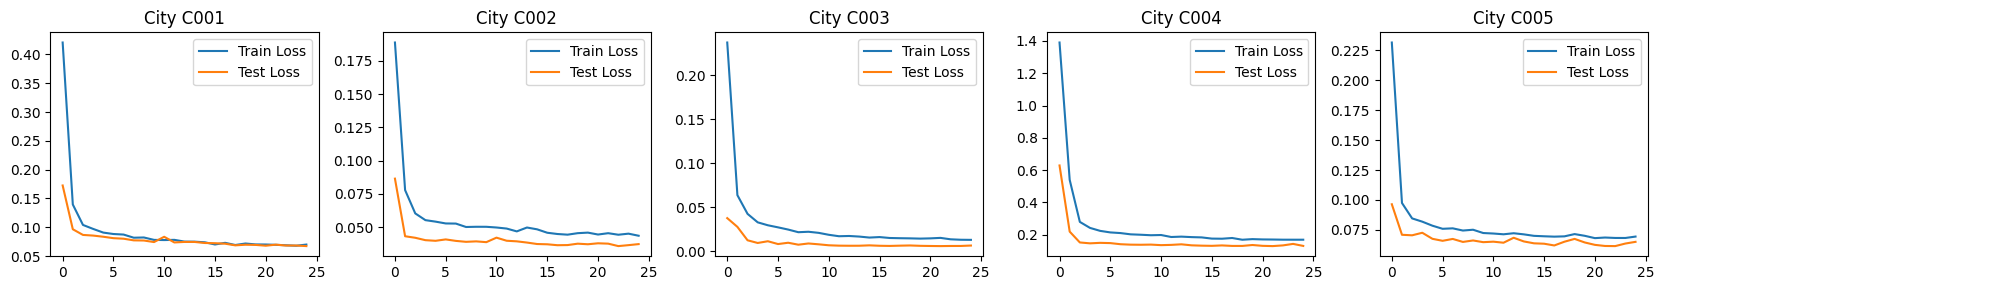

In [27]:
from math import ceil
num_cities = 5
num_rows = ceil(num_cities / 6)
fig, axs = plt.subplots(num_rows, 6, figsize=(20, num_rows * 3))

for i, ax in enumerate(axs.flat):
    if i < num_cities:
        ax.plot(all_train_losses[i], label='Train Loss')
        ax.plot(all_test_losses[i], label='Test Loss')
        ax.set_title(f'City {city_ids[i]}')
        ax.legend()
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
predictions_df = pd.DataFrame(predictions_list)
predictions_df.columns = ['city_id', 'date', 'avg_temp_c']
predictions_df['avg_temp_c'] = predictions_df['avg_temp_c'].round(2)
predictions_df['submission_ID'] = range(1, len(predictions_df) + 1)
predictions_df = predictions_df[['submission_ID', 'city_id', 'date', 'avg_temp_c']]

print(predictions_df)

    submission_ID city_id        date  avg_temp_c
0               1    C001  01/01/2019       -0.90
1               2    C001  02/01/2019       -0.90
2               3    C001  03/01/2019       -0.91
3               4    C001  04/01/2019       -0.91
4               5    C001  05/01/2019       -0.93
5               6    C001  06/01/2019       -0.93
6               7    C001  07/01/2019       -0.92
7               8    C002  01/01/2019       -0.37
8               9    C002  02/01/2019       -0.36
9              10    C002  03/01/2019       -0.37
10             11    C002  04/01/2019       -0.37
11             12    C002  05/01/2019       -0.40
12             13    C002  06/01/2019       -0.40
13             14    C002  07/01/2019       -0.40
14             15    C003  01/01/2019        0.79
15             16    C003  02/01/2019        0.79
16             17    C003  03/01/2019        0.79
17             18    C003  04/01/2019        0.79
18             19    C003  05/01/2019        0.80


In [29]:
predictions_df.to_csv('./../derived_data_csv/output.csv', index=False)